<a href="https://colab.research.google.com/github/transformernlp/explainablility/blob/main/lit_custom_news_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip -q install transformers lit_nlp

     |████████████████████████████████| 2.5MB 13.9MB/s 
     |████████████████████████████████| 604kB 40.1MB/s 
     |████████████████████████████████| 901kB 39.1MB/s 
     |████████████████████████████████| 3.3MB 42.3MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
     |████████████████████████████████| 92kB 9.9MB/s 
     |████████████████████████████████| 1.2MB 38.7MB/s 


In [ ]:
!nvidia-smi

Tue Jun 15 07:17:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    30W /  70W |  15010MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
save_path = '/content/drive/MyDrive/lit_news_classifier/'

In [ ]:
# !rm -rf test_news.csv

In [ ]:
# !rm -rf check/ custom_news_classifier/ test_news.csv

In [ ]:
# !wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
# !unzip -q NewsAggregatorDataset.zip
# !rm -rf __MACOSX/ sample_data/ 2pageSessions.csv NewsAggregatorDataset.zip readme.txt

In [ ]:
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
from torch import cuda

device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [ ]:
df = pd.read_csv('./newsCorpora.csv', sep='\t', names=['ID','TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
df.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [ ]:
df = df[['TITLE','CATEGORY']]
df.head()

,TITLE,CATEGORY
0,"Fed official says weak data caused by weather,...",b
1,Fed's Charles Plosser sees high bar for change...,b
2,US open: Stocks fall after Fed official hints ...,b
3,"Fed risks falling 'behind the curve', Charles ...",b
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b


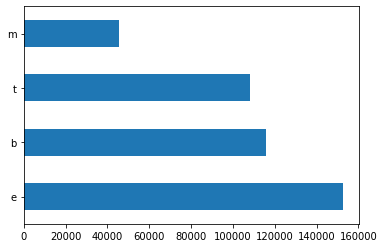

In [ ]:
df.CATEGORY.value_counts().plot(kind='barh')

In [ ]:
# # Converting the codes to appropriate categories using a dictionary
my_dict = {
    'e':'Entertainment',
    'b':'Business',
    't':'Science',
    'm':'Health'
}

def update_cat(x):
    return my_dict[x]

df['CATEGORY'] = df['CATEGORY'].apply(lambda x: my_dict[x])

encode_dict = {}

def encode_cat(x):
    if x not in encode_dict.keys():
        encode_dict[x]=len(encode_dict)
    return encode_dict[x]

df['ENCODE_CAT'] = df['CATEGORY'].apply(lambda x: encode_cat(x))

In [ ]:
df.head()

,TITLE,CATEGORY,ENCODE_CAT
0,"Fed official says weak data caused by weather,...",Business,0
1,Fed's Charles Plosser sees high bar for change...,Business,0
2,US open: Stocks fall after Fed official hints ...,Business,0
3,"Fed risks falling 'behind the curve', Charles ...",Business,0
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,Business,0


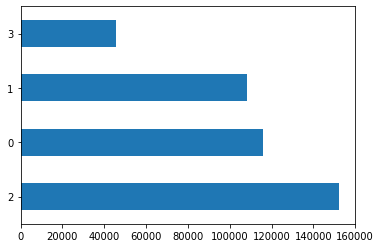

In [ ]:
df.ENCODE_CAT.value_counts().plot(kind='barh')

In [ ]:
df.shape

(422419, 3)

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=333)

In [ ]:
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
test_df.head(2)

,TITLE,CATEGORY,ENCODE_CAT
0,Watch Dogs ctOS Android and iOS apps available...,Science,1
1,"Netflix Orders Comedy Series with Jane Fonda, ...",Entertainment,2


In [ ]:
test_df.shape

(42242, 3)

In [ ]:
test_df.to_csv('/content/drive/MyDrive/test_news.csv', index=False)

In [ ]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 2
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

In [ ]:
class News_DS(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        title = str(self.data.TITLE[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.ENCODE_CAT[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [ ]:
train_size = 0.8
train_dataset=train_df.sample(frac=train_size,random_state=200)
val_dataset=train_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VAL Dataset: {}".format(val_dataset.shape))

training_set = News_DS(train_dataset[:100000], tokenizer, MAX_LEN)
val_set = News_DS(val_dataset[:10000], tokenizer, MAX_LEN)

FULL Dataset: (422419, 3)
TRAIN Dataset: (304142, 3)
VAL Dataset: (76035, 3)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
val_loader = DataLoader(val_set, **val_params)

In [ ]:
len(training_loader), len(val_loader)

(3125, 313)

In [ ]:
# class DistillBERTClass(torch.nn.Module):
#     def __init__(self):
#         super(DistillBERTClass, self).__init__()
#         self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
#         self.pre_classifier = torch.nn.Linear(768, 768)
#         self.dropout = torch.nn.Dropout(0.3)
#         self.classifier = torch.nn.Linear(768, 4)

#     def forward(self, input_ids, attention_mask):
#         output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
#         hidden_state = output_1[0]
#         pooler = hidden_state[:, 0]
#         pooler = self.pre_classifier(pooler)
#         pooler = torch.nn.ReLU()(pooler)
#         pooler = self.dropout(pooler)
#         output = self.classifier(pooler)
#         return output

In [ ]:
%%capture
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(my_dict))
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

In [ ]:
# loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=LEARNING_RATE)

In [ ]:
def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [ ]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(tqdm(training_loader)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        out = model(ids, mask, labels = targets)
        loss = out.loss
        tr_loss += loss.item()
        # big_val, big_idx = torch.max(outputs.data, dim=1)
        # n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%500==0:
            loss_step = tr_loss/nb_tr_steps
            # accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 500 steps: {loss_step}")
            # print(f"Training Accuracy per 500 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    # print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    # epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    # print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [ ]:
for epoch in tqdm(range(EPOCHS)):
    train(epoch)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training Loss per 500 steps: 1.4414308071136475
Training Loss per 500 steps: 1.1578444917044954
Training Loss per 500 steps: 0.9711656452535273
Training Loss per 500 steps: 0.8628466810725833
Training Loss per 500 steps: 0.7809794570939771
Training Loss per 500 steps: 0.7227822033966221
Training Loss per 500 steps: 0.6769985297160401

Training Loss Epoch: 0.6664438902521134


Training Loss per 500 steps: 0.16393369436264038
Training Loss per 500 steps: 0.34309285176460613
Training Loss per 500 steps: 0.33702544996014366
Training Loss per 500 steps: 0.3313639451421395
Training Loss per 500 steps: 0.3266056525553095
Training Loss per 500 steps: 0.3188638345169716
Training Loss per 500 steps: 0.3152357025623759

Training Loss Epoch: 0.3141923803889751



In [ ]:
%%capture
model.to('cpu')

In [ ]:
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/lit_news_classifier/tokenizer_config.json',
 '/content/drive/MyDrive/lit_news_classifier/special_tokens_map.json',
 '/content/drive/MyDrive/lit_news_classifier/vocab.txt',
 '/content/drive/MyDrive/lit_news_classifier/added_tokens.json',
 '/content/drive/MyDrive/lit_news_classifier/tokenizer.json')

In [ ]:
model.save_pretrained(save_path)

In [ ]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu


In [ ]:
acc = valid(model, val_loader)
print("Accuracy on test data = %0.2f%%" % acc)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Validation Loss per 100 steps: 0.35819607973098755
Validation Accuracy per 100 steps: 84.375
Validation Loss Epoch: 0.28701561896469646
Validation Accuracy Epoch: 90.0
Accuracy on test data = 90.00%


In [ ]:
# !zip -r custom_news_classifier.zip custom_news_classifier/

In [ ]:
# from google.colab import files
# files.download('/content/custom_news_classifier.zip')
# files.download('/content/test_news.csv')

In [ ]:
# !ls custom_news_classifier/

In [ ]:
# from transformers import AutoModelForSequenceClassification

In [ ]:
# check = AutoModelForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=4)

In [ ]:
# check.save_pretrained('./check')

In [ ]:
# model.save_pretrained('./custom_news_classifier')

# LIT

In [ ]:
from absl import logging
from lit_nlp.api import model as lit_model
from lit_nlp.api import types as lit_types
from lit_nlp.api import dataset as lit_dataset
from lit_nlp.lib import utils
from lit_nlp import notebook

In [ ]:
def _from_pretrained(cls, *args, **kw):
  """Load a transformers model in PyTorch, with fallback to TF2/Keras weights."""
  try:
    return cls.from_pretrained(*args, **kw)
  except OSError as e:
    logging.warning("Caught OSError loading model: %s", e)
    logging.warning(
        "Re-trying to convert from TensorFlow checkpoint (from_tf=True)")
    return cls.from_pretrained(*args, from_tf=True, **kw)

In [ ]:
class NewsClassificationModel(lit_model.Model):
  """Simple sentiment analysis model."""

  LABELS = ["0", "1", "2", "3"]  # ['Business', 'Science', 'Entertainment', 'Health']

  def __init__(self, model_name_or_path):
    self.tokenizer = transformers.AutoTokenizer.from_pretrained(
        model_name_or_path)
    model_config = transformers.AutoConfig.from_pretrained(
        model_name_or_path,
        num_labels=len(self.LABELS),
        output_hidden_states=True,
        output_attentions=True,
    )
    # This is a just a regular PyTorch model.
    self.model = _from_pretrained(
        transformers.AutoModelForSequenceClassification,
        model_name_or_path,
        config=model_config
        )
    self.model.eval()

  ##
  # LIT API implementation
  def max_minibatch_size(self):
    # This tells lit_model.Model.predict() how to batch inputs to
    # predict_minibatch().
    # Alternately, you can just override predict() and handle batching yourself.
    return 32

  def predict_minibatch(self, inputs):
    # Preprocess to ids and masks, and make the input batch.
    encoded_input = self.tokenizer.batch_encode_plus(
        [ex["TITLE"] for ex in inputs],
        return_tensors="pt",
        add_special_tokens=True,
        max_length=128,
        padding="longest",
        truncation="longest_first")

    # Check and send to cuda (GPU) if available
    if torch.cuda.is_available():
      self.model.cuda()
      for tensor in encoded_input:
        encoded_input[tensor] = encoded_input[tensor].cuda()
    # Run a forward pass.
    with torch.no_grad():  # remove this if you need gradients.
      out: transformers.modeling_outputs.SequenceClassifierOutput = \
          self.model(**encoded_input)

    # Post-process outputs.
    batched_outputs = {
        "probas": torch.nn.functional.softmax(out.logits, dim=-1),
        "input_ids": encoded_input["input_ids"],
        "ntok": torch.sum(encoded_input["attention_mask"], dim=1),
        "cls_emb": out.hidden_states[-1][:, 0],  # last layer, first token
    }
    # Return as NumPy for further processing.
    detached_outputs = {k: v.cpu().numpy() for k, v in batched_outputs.items()}
    # Unbatch outputs so we get one record per input example.
    for output in utils.unbatch_preds(detached_outputs):
      ntok = output.pop("ntok")
      output["tokens"] = self.tokenizer.convert_ids_to_tokens(
          output.pop("input_ids")[1:ntok - 1])
      yield output

  def input_spec(self) -> lit_types.Spec:
    return {
        "TITLE": lit_types.TextSegment(),
        "label": lit_types.CategoryLabel(vocab=self.LABELS, required=False)
    }

  def output_spec(self) -> lit_types.Spec:
    return {
        "tokens": lit_types.Tokens(),
        "probas": lit_types.MulticlassPreds(parent="label", vocab=self.LABELS),
        "cls_emb": lit_types.Embeddings()
    }

In [ ]:
class NewsData(lit_dataset.Dataset):
  
  LABELS = ["0", "1", "2", "3"]  # ['Business', 'Science', 'Entertainment', 'Health']

  def __init__(self, path: str):

    df = pd.read_csv(path)
    df = df.head(100)
    self._examples = [{
      'TITLE': row['TITLE'],
      'label': row['ENCODE_CAT'],
      'CATEGORY': row['CATEGORY']
    } for _, row in df.iterrows()] 

  def spec(self):
    return {
        'TITLE': lit_types.TextSegment(),
        'label': lit_types.CategoryLabel(vocab=self.LABELS),
        'CATEGORY': lit_types.CategoryLabel()
    }

In [ ]:
datasets = {'news_test': NewsData('/content/drive/MyDrive/test_news.csv')}

In [ ]:
model_path = '/content/drive/MyDrive/lit_news_classifier/'

In [ ]:
models = {"news_classifier": NewsClassificationModel(model_path)}

In [ ]:
widget = notebook.LitWidget(models, datasets, height=800)

INFO:absl:
 (    (           
 )\ ) )\ )  *   ) 
(()/((()/(` )  /( 
 /(_))/(_))( )(_))
(_)) (_)) (_(_()) 
| |  |_ _||_   _| 
| |__ | |   | |   
|____|___|  |_|   


INFO:absl:Starting LIT server...
INFO:absl:CachingModelWrapper 'news_classifier': no cache path specified, not loading.


In [ ]:
widget.render()

<IPython.core.display.Javascript object>